Download events (/events/) & matches (/matches/) & players (./players.json) from https://figshare.com/collections/Soccer_match_event_dataset/4415000/3

In [4]:
import pandas as pd
import numpy as np
from collections import ChainMap


# Matches 

In [5]:
def filter_last_minutes_events(events, matchId, minutes=10):
    return events[(events['matchId']==matchId) & (events['matchPeriod']=='2H') & (events['eventSec']>(45-minutes)*60)]

In [6]:
minutes = 10

# Classification

In [7]:
def get_goals_per_game(teamsData):
    keys_team_data = list(teamsData.keys())
    return {keys_team_data[0]:teamsData[keys_team_data[0]]['score'],keys_team_data[1]:teamsData[keys_team_data[1]]['score']}

In [8]:
def get_points_per_score(teamsData): #{'3783': 2, '3767': 1}    
    keys_team_data = list(teamsData.keys())    
    score_match = get_goals_per_game(teamsData)
    if score_match[keys_team_data[0]]==score_match[keys_team_data[1]]:
        return {keys_team_data[0]:1,keys_team_data[1]:1}
    if score_match[keys_team_data[0]]>score_match[keys_team_data[1]]:
        return {keys_team_data[0]:3,keys_team_data[1]:0}
    if score_match[keys_team_data[0]]<score_match[keys_team_data[1]]:
        return {keys_team_data[0]:0,keys_team_data[1]:3}

In [9]:
def get_points_round(round_matches):
    matches_selected = round_matches.sort_values('gameweek')
    dicts = matches_selected.apply(lambda x: get_points_per_score(x['teamsData']), axis=1)
    return dict(ChainMap(*list(dicts)))

In [10]:
def get_points_league(matches):
    all_rounds = {}
    for gameweek, matches_played in matches.groupby('gameweek'):
        all_rounds[gameweek]=get_points_round(matches_played)
    return pd.DataFrame.from_dict(all_rounds)

In [11]:
# points = get_points_league(matches)

In [12]:
def get_points_aggregated_by_round(matches):
    points = get_points_league(matches)
    for round_i in range(2,len(points.columns)+1):
        points[round_i]=points[[round_i-1,round_i]].sum(axis=1)
    return points

In [13]:
# points_agg = get_points_aggregated_by_round(matches)

In [14]:
def get_classification_by_round(matches):
    points_agg = get_points_aggregated_by_round(matches)
    return points_agg.rank(method='first',ascending=False).astype(int)

In [15]:
def get_dict_positions(matches):
    classification = get_classification_by_round(matches)
    dict_positions = {k+1:{} for k in range(len(classification))}
    classification_transposed = classification.transpose()
    for team in classification.index:
        dict_team = classification_transposed.groupby(team).size().to_dict()
        for key in dict_team.keys():
            dict_positions[key][team]=dict_team[key]
    return pd.Series(dict_positions)

In [16]:
def get_frequency_of_position_changes(matches):
    classification = get_classification_by_round(matches)
    all_ranks = [rank for team in classification.values
         for rank in [rank for i, rank in enumerate(team) 
            if i==0 or team[i-1]!=rank]]
    unique, counts = np.unique(all_ranks, return_counts=True)
    return pd.Series(dict(zip(unique, counts)))

In [17]:
def get_jensen_breaks(matches):
    classification_points = get_points_aggregated_by_round(matches)
    last_round = classification_points[classification_points.columns[len(classification_points.columns)-1]].sort_values(ascending=False)
    import jenkspy
    breaks = jenkspy.jenks_breaks(last_round, nb_class=4)
    breaks[0]=-1
    cut_classification = pd.cut(last_round, breaks, labels=[4,3,2,1])
    cut_classification.index = range(1,len(last_round)+1)
    return cut_classification

`conda install -c conda-forge jenkspy`

In [18]:

#freq.plot.barh()

In [19]:
competitions = [{'name':'France', 'column_name':'🇫🇷'},
               {'name':'England', 'column_name':'🏴󠁧󠁢󠁥󠁮󠁧󠁿'},
               {'name':'Germany', 'column_name':'🇩🇪'},
               {'name':'Italy', 'column_name':'🇮🇹'},
               {'name':'Spain', 'column_name':'🇪🇸'}]
all_competitions=[]
for competition in competitions:
    events = pd.read_json('events/events_{}.json'.format(competition['name'])).set_index('id')
    matches = pd.read_json('matches/matches_{}.json'.format(competition['name'])).set_index('wyId')
    players = pd.read_json('players.json').set_index('wyId')
    freq = get_frequency_of_position_changes(matches)
    all_data = pd.concat([get_jensen_breaks(matches),freq],axis=1, keys=['jensen','freq'])
    all_data['League']=competition['column_name']
    all_competitions.append(all_data)

In [20]:
#t=25
#exagerate_freq = freq.apply(lambda x: np.exp(x/t))
#exagerate_freq.plot.barh()

In [21]:
#all_competitions
final_data = pd.concat(all_competitions)

In [22]:
final_data.index.name='position'
final_data = final_data.reset_index()

In [23]:
import altair as alt
import numpy as np
import pandas as pd

In [24]:
final_data.head()

,position,jensen,freq,League
0,1,1,2,🇫🇷
1,2,2,10,🇫🇷
2,3,2,15,🇫🇷
3,4,2,13,🇫🇷
4,5,3,16,🇫🇷


In [25]:
added = None
all_leagues = final_data['League'].unique()
for i,league in enumerate(all_leagues):
    league_data = final_data[final_data['League']==league]
    y1=alt.Y('position:O', title='')
    if i!=0:
        y1 = alt.Y('position:O', title='', axis=None)
    a = alt.Chart(league_data).mark_bar().encode(    
        y=y1,
        color=alt.Color('freq:Q', scale=alt.Scale(scheme="purples",domain=[np.min(final_data['freq']),np.max(final_data['freq'])]),legend=None)    
    ).properties(
        width=20,
        height=400,
        title=league
    )
    b = alt.Chart(league_data).mark_bar().encode(
        y=alt.Y('position:O', title='', axis=None),
        color=alt.Color('jensen:O', scale=alt.Scale(scheme="redyellowgreen"),legend=None,sort="descending")    
    ).properties(
        width=20,
        height=400
    )
    ab = alt.hconcat(a,b,spacing=3)
    if not added:
        added=ab
    else:
        added=alt.hconcat(added,ab,spacing=15)

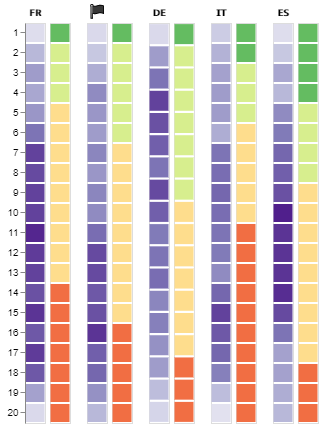

In [26]:
added

In [27]:
alt.Resolve(scale=alt.LegendResolveMap(color=alt.ResolveMode('independent')))

Resolve({
  scale: LegendResolveMap({
    color: ResolveMode('independent')
  })
})

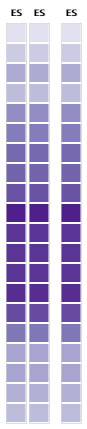

In [339]:
alt.hconcat(alt.hconcat(a,a, spacing=1),a,spacing=10)

In [317]:
alt.hconcat.padding

AttributeError: 'function' object has no attribute 'padding'

In [313]:
a.properties(padding=5)

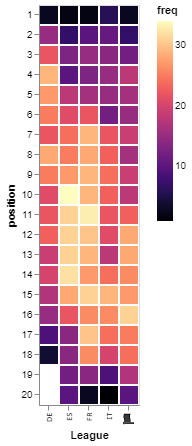

In [167]:
#final_data['type']=pd.cut(final_data.index,6, labels=range(0,6))
alt.Chart(final_data).mark_bar().encode(
    x='League:O',
    y='position:O',
    color=alt.Color('freq:Q', scale=alt.Scale(scheme="magma"))
    #column='League:O'
)

In [229]:
colorEnc = alt.Color('freq:Q', scale=alt.Scale(scheme="magma"),legend=None,sort="descending")
colorEnc

Color({
  legend: None,
  scale: Scale({
    scheme: 'magma'
  }),
  shorthand: 'freq:Q',
  sort: 'descending'
})

In [155]:
b =alt.Chart(final_data).mark_bar().encode(
    y='position:O',
    color=alt.Color('freq:Q', scale=alt.Scale(scheme="magma")),
    column='League:O'
).properties(
    height=300,
    width=300
)

In [157]:
a|a

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


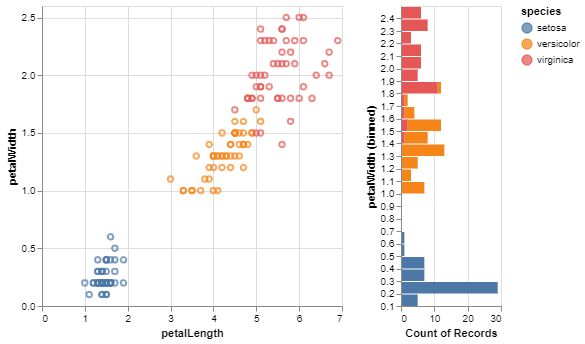

In [359]:
import altair as alt
from vega_datasets import data

iris = data.iris.url

chart1 = alt.Chart(iris).mark_point().encode(
    x='petalLength:Q',
    y='petalWidth:Q',
    color='species:N'
).properties(
    height=300,
    width=300
)

chart2 = alt.Chart(iris).mark_bar().encode(
    x='count()',
    y=alt.Y('petalWidth:Q', bin=alt.Bin(maxbins=30)),
    color='species:N'
).properties(
    height=300,
    width=100
)

chart1 | chart2

In [305]:
chart1 = alt.Chart(iris).mark_bar().encode(
    x='petalLength:Q',
    y='petalWidth:Q',
    color='species:N'
).properties(
    height=300,
    width=300
)


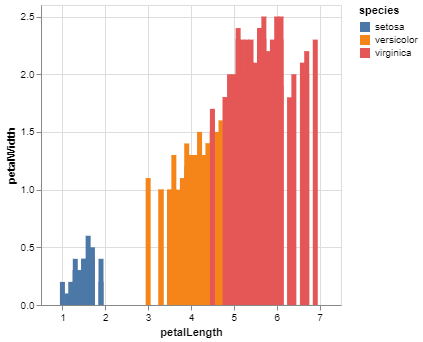

In [306]:
chart1

In [24]:
alt.Chart(data.movies.url).mark_rect().encode(
    alt.X('IMDB_Rating:Q', bin=True),
    alt.Y('Rotten_Tomatoes_Rating:Q', bin=True),
    alt.Color('count()',
        scale=alt.Scale(scheme='greenblue'),
        #legend=alt.Legend(title='Total Records')
    )
)|alt.Chart(data.movies.url).mark_rect().encode(
    alt.X('IMDB_Rating:Q'),
    alt.Y('Rotten_Tomatoes_Rating:Q'),
    alt.Color('count()',
        scale=alt.Scale(scheme='magma'),
        #legend=alt.Legend(title='Total Records')
    )
)

NameError: name 'data' is not defined